In [1]:
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import extract
import visualize
from sklearn import tree
import pydotplus
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [2]:
s_jan = pd.read_csv("./data/sale_to_customer_rl_10_mm_20000_price_change_data.csv", usecols = ['d_index',
		'cusip', 'state', 'coupon', 'maturity', 'yield', 'issuetype', 'issuesource', 'rtg',
		'tradedate', 'price', 'dprice', 'holdtime'])

In [3]:
s_feb = pd.read_csv("./data/sale_to_customer_rl_10_mm_20000_price_change_data_february.csv", usecols = ['d_index',
		'cusip', 'state', 'coupon', 'maturity', 'yield', 'issuetype', 'issuesource', 'rtg',
		'tradedate', 'price', 'dprice', 'holdtime'])

In [4]:
d_index_jan = s_jan.pop('d_index')
d_index_feb = s_feb.pop('d_index')

In [5]:
s_jan.head()

,cusip,price,yield,tradedate,state,coupon,maturity,issuetype,issuesource,rtg,dprice,holdtime
0,45471AKG6,99.41,4.045,2.0,Indiana,4.0,6692.0,ISSUE TYPE: REVENUE BONDS,"ISSUE SOURCE: HLTH, HOSP, NURSHOME REV.",6,0.573,1.0
1,45471AKG6,99.41,4.045,2.0,Indiana,4.0,6692.0,ISSUE TYPE: REVENUE BONDS,"ISSUE SOURCE: HLTH, HOSP, NURSHOME REV.",6,0.585,2.0
2,45471AKG6,99.41,4.045,2.0,Indiana,4.0,6692.0,ISSUE TYPE: REVENUE BONDS,"ISSUE SOURCE: HLTH, HOSP, NURSHOME REV.",6,3.336,8.0
3,45471AKG6,99.41,4.045,2.0,Indiana,4.0,6692.0,ISSUE TYPE: REVENUE BONDS,"ISSUE SOURCE: HLTH, HOSP, NURSHOME REV.",6,3.186,9.0
4,45471AKG6,99.41,4.045,2.0,Indiana,4.0,6692.0,ISSUE TYPE: REVENUE BONDS,"ISSUE SOURCE: HLTH, HOSP, NURSHOME REV.",6,3.573,9.0


In [6]:
s_feb.head()

,cusip,tradedate,maturity,price,yield,coupon,state,issuetype,issuesource,rtg,dprice,holdtime
0,13080SMW1,45.531944,3467.468056,100.0,3.999,4.0,California,ISSUE TYPE: REVENUE BONDS,"ISSUE SOURCE: HLTH, HOSP, NURSHOME REV.",5,0.0,0.007639
1,13080SMW1,45.531944,3467.468056,100.0,3.999,4.0,California,ISSUE TYPE: REVENUE BONDS,"ISSUE SOURCE: HLTH, HOSP, NURSHOME REV.",5,0.0,0.013889
2,13080SMW1,45.531944,3467.468056,100.0,3.999,4.0,California,ISSUE TYPE: REVENUE BONDS,"ISSUE SOURCE: HLTH, HOSP, NURSHOME REV.",5,0.0,0.081250
3,13080SMW1,45.531944,3467.468056,100.0,3.999,4.0,California,ISSUE TYPE: REVENUE BONDS,"ISSUE SOURCE: HLTH, HOSP, NURSHOME REV.",5,0.0,0.081944
4,13080SMW1,45.531944,3467.468056,100.0,3.999,4.0,California,ISSUE TYPE: REVENUE BONDS,"ISSUE SOURCE: HLTH, HOSP, NURSHOME REV.",5,0.0,0.130556


In [7]:
s_jan_state_features = extract.build_state_features(s_jan, num_states = None)
s_jan_other_features = extract.build_other_text_features(s_jan, tradetype=False)
s_jan_t = pd.concat([s_jan.drop(['state', 'issuetype', 'issuesource', 'cusip', 'price'], axis = 1), s_jan_state_features, s_jan_other_features], axis = 1)
s_jan_t = s_jan_t.dropna()
s_jan_t = s_jan_t[s_jan_t.holdtime < 7] #pick out only data with holdtime < 7 days

In [8]:
s_jan_t.head()

,yield,tradedate,coupon,maturity,rtg,dprice,holdtime,Alabama,Alaska,Arizona,...,ISSUE SOURCE: SALES TAX REVENUE,ISSUE SOURCE: SEWER REVENUE,ISSUE SOURCE: SPECIAL ASSESSMENT,ISSUE SOURCE: SPECIAL TAX,ISSUE SOURCE: STUDENT LOAN REVENUE,ISSUE SOURCE: TAX INCRMT./ALLCTN.REV.,ISSUE SOURCE: TOBACCO & LIQUOR TAXES,ISSUE SOURCE: TOBACCO SETTLEMENT FUNDED,ISSUE SOURCE: TRANSIT REVENUE,ISSUE SOURCE: WATER REVENUE
0,4.045,2.0,4.0,6692.0,6,0.573,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4.045,2.0,4.0,6692.0,6,0.585,2.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,4.000,3.0,4.0,6691.0,6,0.012,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,4.000,4.0,4.0,6690.0,6,2.751,6.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,3.508,10.0,4.0,6684.0,6,-0.150,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
s_feb_state_features = extract.build_state_features(s_feb, num_states = None)
s_feb_other_features = extract.build_other_text_features(s_feb, tradetype=False)
s_feb_t = pd.concat([s_feb.drop(['state', 'issuetype', 'issuesource', 'cusip', 'price'], axis = 1), s_feb_state_features, s_feb_other_features], axis = 1)
s_feb_t = s_feb_t.dropna()
s_feb_t = s_feb_t[s_feb_t.holdtime < 7] #pick out only data with holdtime < 7 days

In [10]:
s_feb_t.head()

,tradedate,maturity,yield,coupon,rtg,dprice,holdtime,California,Illinois,Louisiana,New Jersey,ISSUE TYPE: GENERAL OBLIGATION UNLTD,ISSUE TYPE: REVENUE BONDS,ISSUE SOURCE: AD VALOREM PROPERTY TAX,ISSUE SOURCE: APPROPRIATIONS,"ISSUE SOURCE: HLTH, HOSP, NURSHOME REV.",ISSUE SOURCE: WATER REVENUE
0,45.531944,3467.468056,3.999,4.0,5,0.0,0.007639,1,0,0,0,0,1,0,0,1,0
1,45.531944,3467.468056,3.999,4.0,5,0.0,0.013889,1,0,0,0,0,1,0,0,1,0
2,45.531944,3467.468056,3.999,4.0,5,0.0,0.081250,1,0,0,0,0,1,0,0,1,0
3,45.531944,3467.468056,3.999,4.0,5,0.0,0.081944,1,0,0,0,0,1,0,0,1,0
4,45.531944,3467.468056,3.999,4.0,5,0.0,0.130556,1,0,0,0,0,1,0,0,1,0


### add columns of zeros to either set for one-hot features that are not present in one or other

In [11]:
jan_features = set(s_jan_t.columns)
feb_features = set(s_feb_t.columns)
for feature in jan_features - feb_features:
    s_feb_t[feature] = 0

for feature in feb_features - jan_features:
    s_jan_t[feature] = 0

In [12]:
dprice_jan = s_jan_t.pop('dprice')
dprice_feb = s_feb_t.pop('dprice')

In [13]:
clf = RandomForestRegressor(max_depth = 20, n_estimators = 100)

In [14]:
clf.fit(s_jan_t, dprice_jan)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

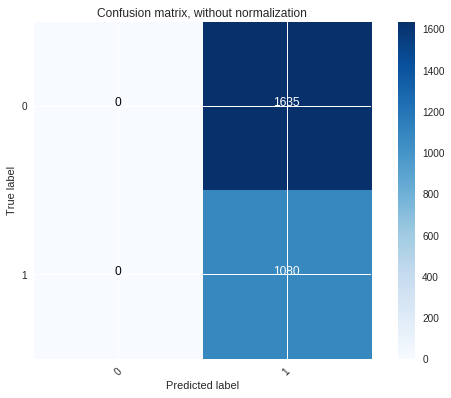

In [16]:
dp_predict = clf.predict(s_feb_t)
#dp_predict_old = clf.predict(s_jan_1)
cnf_matrix = confusion_matrix((dprice_feb>0).astype(np.int), (dp_predict>0).astype(np.int))
plt.figure()
visualize.plot_confusion_matrix(cnf_matrix, classes=[0, 1], title='Confusion matrix, without normalization')
plt.show()

In [102]:
dprice_new[dprice_new > 0]

177     0.281
192     0.375
223     0.176
229     0.075
951     0.266
956     0.334
962     0.724
966     0.722
967     0.030
1062    0.079
1066    0.077
Name: dprice, dtype: float64

96.525000000000006

100.7

In [106]:
np.sqrt(np.sum((dp_predict - dprice_new.values)**2)/dprice_new.shape[0])

1.4072970650219945

In [107]:
dp_predict[:10]

array([-0.29416135, -0.29416135, -0.29416135, -0.29416135, -0.29416135,
       -0.29858335, -0.29858335, -0.29858335, -0.34630401, -0.26251347])

In [108]:
dprice_new[:10]

0   -2.060
1   -2.060
2   -3.475
3   -2.060
4   -2.060
5   -2.000
6   -2.000
7   -2.000
8   -1.750
9   -2.060
Name: dprice, dtype: float64

In [117]:
s_jan.columns

Index([u'coupon', u'cusip', u'maturity', u'name', u'price', u'rtg',
       u'tradedate', u'yield', u'Alabama', u'Alaska',
       ...
       u'SPECIAL TAX', u'STUDENT LOAN REVENUE', u'TAX INCRMT./ALLCTN.REV.',
       u'TELECOM REVENUE', u'TOBACCO & LIQUOR TAXES',
       u'TOBACCO SETTLEMENT FUNDED', u'TRANSIT REVENUE', u'WATER REVENUE',
       u'tradetype', u'holdtime'],
      dtype='object', length=114)

In [118]:
dprice_jan[:10]

0   -0.762
1    0.376
2    0.473
3    1.614
4    1.272
5   -0.211
6    0.126
7   -0.306
8   -2.240
9   -0.665
Name: dprice, dtype: float64

In [119]:
dprice_jan.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            77175, 77176, 77177, 77178, 77179, 77180, 77181, 77182, 77183,
            77184],
           dtype='int64', length=77185)

In [120]:
s_jan.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            77175, 77176, 77177, 77178, 77179, 77180, 77181, 77182, 77183,
            77184],
           dtype='int64', length=77185)

In [152]:
r = -float('infinity')
for s in s_jan.cusip.unique():
    I = s_jan.cusip == s
    n = dprice_jan[I].mean()*np.sum(dprice_jan[I] > 0)
    if n > r:
        r = n
        s_best = s
        

In [153]:
s_best

'57563RNV7'

In [154]:
r

49.280923664122113

In [155]:
P = dprice_jan[s_jan.cusip == s_best]

In [156]:
np.sum(P < 0)

51

In [157]:
np.sum(P > 0)

79

In [158]:
P.mean()

0.62380916030534317

In [159]:
P.mean()*np.sum(P>0)

49.280923664122113